In [0]:
import numpy as np

import copy
import torch
from torch import optim
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, utils
from IPython.display import display
from PIL import Image
import pandas as pd
import numpy as np
import math
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
PATH_TO_DATA = '/content/drive/My Drive/MATT/MLEARN/MLEARN.zip (Unzipped Files)/MLEARN/00Data'

In [0]:
# Random Seed
torch.manual_seed(1)
np.random.seed(1)

# Select the available device
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
  torch.cuda.manual_seed_all(1)

In [0]:
data2 = pd.read_csv(PATH_TO_DATA+'/Generated/DB20191209.csv')
data = pd.read_csv(PATH_TO_DATA+'/Generated/DB20200101.csv')

In [6]:
data.head()

,Unnamed: 0,B365H,B365D,B365A,FTR,Date,HomeTeam,AwayTeam,HomeTeamPercPoints,HomeTeamGolsFavorMean,HomeTeamGolsFavorMedian,HomeTeamGolsFavorMax,HomeTeamGolsContraMean,HomeTeamGolsContraMedian,HomeTeamGolsContraMax,HomeTeam_Position,HomeTeam_Home_Wins_season,HomeTeam_Away_Wins_season,HomeTeam_Wins_season,HomeTeam_Home_Lose_season,HomeTeam_Away_Lose_season,HomeTeam_Lose_season,HomeTeam_Home_Draw_season,HomeTeam_Away_Draw_season,HomeTeam_Draw_season,HomeTeam_Points,HomeTeam_Home_goals_avg,HomeTeam_Home_goals_med,HomeTeam_Home_goals_max,HomeTeam_Home_goals_mode,HomeTeam_Away_goals_avg,HomeTeam_Away_goals_med,HomeTeam_Away_goals_max,HomeTeam_Away_goals_mode,HomeTeam_AgeMean,HomeTeam_AgeMedian,HomeTeam_DefensaMax,HomeTeam_DefensaMean,HomeTeam_DefensaMedian,HomeTeam_DelanteroMax,...,AwayTeamGolsContraMax,AwayTeam_Position,AwayTeam_Home_Wins_season,AwayTeam_Away_Wins_season,AwayTeam_Wins_season,AwayTeam_Home_Lose_season,AwayTeam_Away_Lose_season,AwayTeam_Lose_season,AwayTeam_Home_Draw_season,AwayTeam_Away_Draw_season,AwayTeam_Draw_season,AwayTeam_Points,AwayTeam_Home_goals_avg,AwayTeam_Home_goals_med,AwayTeam_Home_goals_max,AwayTeam_Home_goals_mode,AwayTeam_Away_goals_avg,AwayTeam_Away_goals_med,AwayTeam_Away_goals_max,AwayTeam_Away_goals_mode,AwayTeam_AgeMean,AwayTeam_AgeMedian,AwayTeam_DefensaMax,AwayTeam_DefensaMean,AwayTeam_DefensaMedian,AwayTeam_DelanteroMax,AwayTeam_DelanteroMean,AwayTeam_DelanteroMedian,AwayTeam_MedioMax,AwayTeam_MedioMean,AwayTeam_MedioMedian,AwayTeam_OverallMax,AwayTeam_OverallMean,AwayTeam_OverallMedian,AwayTeam_PorteroMax,AwayTeam_PorteroMean,AwayTeam_PorteroMedian,AwayTeam_TopOverallMean,AwayTeam_TopOverallMedian,AwayTeam_TopOverallMin
0,0,2.2,3.2,3.50,D,26/08/2016,Betis,La Coruna,0.000000,2.0,2.0,2,6.0,6.0,6,10,6,5,11,7,8,15,6,6,12,45,0.894737,1.0,2,1,0.894737,1.0,3,1,26.142857,25.0,78.0,73.555556,73.0,81.0,...,1,15,4,4,8,7,5,12,8,10,18,42,1.315789,1.0,3,2,1.052632,1.0,3,1,25.666667,25.0,79.0,74.625000,75.0,79.0,68.500000,67.0,79.0,72.062500,74.0,79.0,72.151515,75.0,75.0,73.333333,75.0,77.272727,77.0,61.0
1,1,2.3,3.1,3.40,D,26/08/2016,Espanol,Malaga,0.000000,4.0,4.0,4,6.0,6.0,6,14,9,3,12,5,14,19,5,2,7,43,1.157895,1.0,4,1,0.947368,1.0,4,0,26.142857,26.0,77.0,73.666667,76.0,80.0,...,1,9,8,4,12,5,9,14,6,6,12,48,1.368421,1.0,4,1,0.631579,0.0,3,0,25.000000,24.0,78.0,73.181818,75.0,77.0,68.875000,71.0,81.0,75.909091,76.0,81.0,73.090909,75.0,81.0,73.666667,78.0,78.272727,78.0,58.0
2,2,2.7,3.2,2.75,H,27/08/2016,Eibar,Valencia,0.000000,1.0,1.0,1,2.0,2.0,2,13,8,3,11,6,11,17,5,5,10,43,1.368421,1.0,5,1,1.210526,1.0,4,0,25.096774,25.0,79.0,72.000000,75.0,78.0,...,4,12,6,5,11,6,10,16,7,4,11,44,1.315789,1.0,4,0,1.105263,1.0,5,0,24.333333,24.0,83.0,74.166667,76.5,83.0,76.375000,76.5,81.0,71.400000,72.5,83.0,73.878788,76.0,82.0,74.333333,75.0,80.181818,79.0,61.0
3,3,8.5,3.6,1.53,D,27/08/2016,Leganes,Ath Madrid,1.000000,1.0,1.0,1,0.0,0.0,0,19,6,3,9,6,14,20,7,2,9,36,1.210526,1.0,4,1,0.736842,0.0,2,0,25.454545,25.0,76.0,70.909091,74.0,73.0,...,1,3,15,13,28,1,5,6,3,1,4,88,1.736842,1.0,5,1,1.578947,1.0,3,1,25.419355,24.0,88.0,77.666667,82.0,88.0,75.666667,80.0,84.0,76.416667,80.5,88.0,76.548387,81.0,87.0,75.750000,75.5,84.636364,84.0,61.0
4,4,3.1,3.1,2.50,A,27/08/2016,Osasuna,Sociedad,0.333333,1.0,1.0,1,1.0,1.0,1,20,7,1,8,7,15,22,5,3,8,32,1.210526,1.0,3,1,0.736842,1.0,3,0,26.030303,27.0,75.0,71.727273,72.0,76.0,...,3,8,7,6,13,7,9,16,5,4,9,48,1.157895,1.0,3,2,1.210526,1.0,5,0,24.939394,24.0,81.0,72.700000,75.5,82.0,74.666667,77.5,79.0,72.230769,73.0,83.0,72.636364,75.0,83.0,70.750000,67.0,79.272727,79.0,60.0


In [0]:
data = data.drop(columns=['Unnamed: 0','HomeTeam','AwayTeam'])

In [0]:
data['B365H'] = 1/data['B365H']
data['B365D'] = 1/data['B365D']
data['B365A'] = 1/data['B365A']
data['Sum'] = data['B365H'] + data['B365D'] + data['B365A'] 
data['B365H'] = data['B365H']/data['Sum']
data['B365D'] = data['B365D']/data['Sum']
data['B365A'] = data['B365A']/data['Sum']

In [9]:
data.head()

,B365H,B365D,B365A,FTR,Date,HomeTeamPercPoints,HomeTeamGolsFavorMean,HomeTeamGolsFavorMedian,HomeTeamGolsFavorMax,HomeTeamGolsContraMean,HomeTeamGolsContraMedian,HomeTeamGolsContraMax,HomeTeam_Position,HomeTeam_Home_Wins_season,HomeTeam_Away_Wins_season,HomeTeam_Wins_season,HomeTeam_Home_Lose_season,HomeTeam_Away_Lose_season,HomeTeam_Lose_season,HomeTeam_Home_Draw_season,HomeTeam_Away_Draw_season,HomeTeam_Draw_season,HomeTeam_Points,HomeTeam_Home_goals_avg,HomeTeam_Home_goals_med,HomeTeam_Home_goals_max,HomeTeam_Home_goals_mode,HomeTeam_Away_goals_avg,HomeTeam_Away_goals_med,HomeTeam_Away_goals_max,HomeTeam_Away_goals_mode,HomeTeam_AgeMean,HomeTeam_AgeMedian,HomeTeam_DefensaMax,HomeTeam_DefensaMean,HomeTeam_DefensaMedian,HomeTeam_DelanteroMax,HomeTeam_DelanteroMean,HomeTeam_DelanteroMedian,HomeTeam_MedioMax,...,AwayTeam_Position,AwayTeam_Home_Wins_season,AwayTeam_Away_Wins_season,AwayTeam_Wins_season,AwayTeam_Home_Lose_season,AwayTeam_Away_Lose_season,AwayTeam_Lose_season,AwayTeam_Home_Draw_season,AwayTeam_Away_Draw_season,AwayTeam_Draw_season,AwayTeam_Points,AwayTeam_Home_goals_avg,AwayTeam_Home_goals_med,AwayTeam_Home_goals_max,AwayTeam_Home_goals_mode,AwayTeam_Away_goals_avg,AwayTeam_Away_goals_med,AwayTeam_Away_goals_max,AwayTeam_Away_goals_mode,AwayTeam_AgeMean,AwayTeam_AgeMedian,AwayTeam_DefensaMax,AwayTeam_DefensaMean,AwayTeam_DefensaMedian,AwayTeam_DelanteroMax,AwayTeam_DelanteroMean,AwayTeam_DelanteroMedian,AwayTeam_MedioMax,AwayTeam_MedioMean,AwayTeam_MedioMedian,AwayTeam_OverallMax,AwayTeam_OverallMean,AwayTeam_OverallMedian,AwayTeam_PorteroMax,AwayTeam_PorteroMean,AwayTeam_PorteroMedian,AwayTeam_TopOverallMean,AwayTeam_TopOverallMedian,AwayTeam_TopOverallMin,Sum
0,0.431766,0.296839,0.271396,D,26/08/2016,0.000000,2.0,2.0,2,6.0,6.0,6,10,6,5,11,7,8,15,6,6,12,45,0.894737,1.0,2,1,0.894737,1.0,3,1,26.142857,25.0,78.0,73.555556,73.0,81.0,71.400000,75.0,79.0,...,15,4,4,8,7,5,12,8,10,18,42,1.315789,1.0,3,2,1.052632,1.0,3,1,25.666667,25.0,79.0,74.625000,75.0,79.0,68.500000,67.0,79.0,72.062500,74.0,79.0,72.151515,75.0,75.0,73.333333,75.0,77.272727,77.0,61.0,1.052760
1,0.413495,0.306787,0.279718,D,26/08/2016,0.000000,4.0,4.0,4,6.0,6.0,6,14,9,3,12,5,14,19,5,2,7,43,1.157895,1.0,4,1,0.947368,1.0,4,0,26.142857,26.0,77.0,73.666667,76.0,80.0,73.000000,75.0,79.0,...,9,8,4,12,5,9,14,6,6,12,48,1.368421,1.0,4,1,0.631579,0.0,3,0,25.000000,24.0,78.0,73.181818,75.0,77.0,68.875000,71.0,81.0,75.909091,76.0,81.0,73.090909,75.0,81.0,73.666667,78.0,78.272727,78.0,58.0,1.051481
2,0.353911,0.298613,0.347476,H,27/08/2016,0.000000,1.0,1.0,1,2.0,2.0,2,13,8,3,11,6,11,17,5,5,10,43,1.368421,1.0,5,1,1.210526,1.0,4,0,25.096774,25.0,79.0,72.000000,75.0,78.0,70.500000,72.5,79.0,...,12,6,5,11,6,10,16,7,4,11,44,1.315789,1.0,4,0,1.105263,1.0,5,0,24.333333,24.0,83.0,74.166667,76.5,83.0,76.375000,76.5,81.0,71.400000,72.5,83.0,73.878788,76.0,82.0,74.333333,75.0,80.181818,79.0,61.0,1.046507
3,0.112150,0.264798,0.623053,D,27/08/2016,1.000000,1.0,1.0,1,0.0,0.0,0,19,6,3,9,6,14,20,7,2,9,36,1.210526,1.0,4,1,0.736842,0.0,2,0,25.454545,25.0,76.0,70.909091,74.0,73.0,69.500000,71.0,77.0,...,3,15,13,28,1,5,6,3,1,4,88,1.736842,1.0,5,1,1.578947,1.0,3,1,25.419355,24.0,88.0,77.666667,82.0,88.0,75.666667,80.0,84.0,76.416667,80.5,88.0,76.548387,81.0,87.0,75.750000,75.5,84.636364,84.0,61.0,1.049020
4,0.308642,0.308642,0.382716,A,27/08/2016,0.333333,1.0,1.0,1,1.0,1.0,1,20,7,1,8,7,15,22,5,3,8,32,1.210526,1.0,3,1,0.736842,1.0,3,0,26.030303,27.0,75.0,71.727273,72.0,76.0,69.333333,70.0,77.0,...,8,7,6,13,7,9,16,5,4,9,48,1.157895,1.0,3,2,1.210526,1.0,5,0,24.939394,24.0,81.0,72.700000,75.5,82.0,74.666667,77.5,79.0,72.230769,73.0,83.0,72.636364,75.0,83.0,70.750000,67.0,79.272727,79.0,60.0,1.045161


In [0]:
del data['Sum']

In [0]:
class Dataset(object):
    """An abstract class representing a Dataset.
    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

In [0]:
class DatasetDF(Dataset):
    
    def __init__(self, data, ftrs, dates):
        self.data = data
        self.transform = torch.FloatTensor
        self.ftrs = ftrs
        self.dates = dates
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        sample = self.data.iloc[index, 4:].values
        label = self.data.iloc[index, :3]
        sample = np.array(list(sample), dtype=np.float)
        label = np.array(list(label), dtype=np.float)
        ftr = self.ftrs[index]
        date = self.dates[index]
        
        return self.transform(sample), self.transform(label), ftr, date

In [0]:
hparams1 = {
    'num_epochs': 15,
    'batch_size': 5,
    'test_batch_size': 5,
    'criterion': F.mse_loss,
    'learning_rate': 1e-3,
    'log_interval': 40,
}

In [0]:
dataset = DatasetDF(data.drop(columns='FTR'), data['FTR'], data['Date'])

In [0]:
num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(0.15 * num_train))
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [0]:
train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=hparams1['batch_size'], 
    sampler=train_sampler)
train_iter = iter(train_loader)

valid_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=hparams1['test_batch_size'], 
    sampler=valid_sampler)
valid_iter = iter(valid_loader)

In [17]:
dataset.__getitem__(0)

(tensor([ 0.0000,  2.0000,  2.0000,  2.0000,  6.0000,  6.0000,  6.0000, 10.0000,
          6.0000,  5.0000, 11.0000,  7.0000,  8.0000, 15.0000,  6.0000,  6.0000,
         12.0000, 45.0000,  0.8947,  1.0000,  2.0000,  1.0000,  0.8947,  1.0000,
          3.0000,  1.0000, 26.1429, 25.0000, 78.0000, 73.5556, 73.0000, 81.0000,
         71.4000, 75.0000, 79.0000, 74.8182, 76.0000, 81.0000, 73.6786, 75.5000,
         81.0000, 73.6667, 70.0000, 78.1818, 78.0000, 60.0000,  1.0000,  2.0000,
          2.0000,  2.0000,  1.0000,  1.0000,  1.0000, 15.0000,  4.0000,  4.0000,
          8.0000,  7.0000,  5.0000, 12.0000,  8.0000, 10.0000, 18.0000, 42.0000,
          1.3158,  1.0000,  3.0000,  2.0000,  1.0526,  1.0000,  3.0000,  1.0000,
         25.6667, 25.0000, 79.0000, 74.6250, 75.0000, 79.0000, 68.5000, 67.0000,
         79.0000, 72.0625, 74.0000, 79.0000, 72.1515, 75.0000, 75.0000, 73.3333,
         75.0000, 77.2727, 77.0000, 61.0000]),
 tensor([0.4318, 0.2968, 0.2714]),
 'D',
 '26/08/2016')

In [0]:
def train_epoch(model, hparams, loader, optimizer, device, epoch):
    losses = []
    model.train()
    for batch_idx, (data, target, _, _) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        criterion = hparams['criterion']
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % hparams['log_interval'] == 0:
            dataset_len = len(loader) * hparams['batch_size']
            processed_data_len = batch_idx * hparams['batch_size']
            processed_data_len_str = format(processed_data_len, '0'+str(len(str(dataset_len))))
            processed_ratio = round((100. * batch_idx / len(loader)),0)
            loss_str = str(round(loss.item(),6))
            print(f"Train Epoch: {epoch} [{processed_data_len_str}/{dataset_len} "+\
                  f"({processed_ratio}%)]\tLoss: {loss_str}")
    return losses

In [0]:
def validate_epoch(model, hparams, loader, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for data, target, _, _ in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            criterion = hparams['criterion']
            loss = criterion(output, target)
            losses.append(loss.item())
    
    avg_loss = sum(losses) / len(losses)
    validation_loss_str = str(round(avg_loss,6))
    print(f"\nValidation:\t\t\t\tLoss: {validation_loss_str} (avg.)\n\n")
    
    return avg_loss

In [0]:
def train(model, hparams, train_loader, valid_loader, optimizer, device):
    train_losses = []
    valid_losses = []
    valid_x = []
    for epoch in range(1, hparams['num_epochs'] + 1):
        epoch_train_losses = train_epoch(model, hparams, train_loader,
                                         optimizer, device, epoch)
        train_losses.extend(epoch_train_losses)
        epoch_valid_loss = validate_epoch(model, hparams, valid_loader, device)
        valid_losses.append(epoch_valid_loss)
        valid_x.append(len(train_losses) - 1)

    train_x = range(len(train_losses))

    return (train_x, train_losses), (valid_x, valid_losses)

In [0]:
def compute_avg_mse(model, loader):
    avg_mse = []
    for inputs, _, _, _ in iter(loader):
        outputs = model(inputs.to(device))
        outputs = outputs.detach().cpu().numpy()
        for input_, output in zip(inputs, outputs):
            mse = (np.square(input_.detach().cpu().numpy() - output)).mean(axis=None)
            avg_mse.append(mse)
    avg_mse = sum(avg_mse) / len(avg_mse)
    return avg_mse

In [22]:
img, lab, ftr, date = dataset.__getitem__(0)

print(img.shape)
print(type(img))
print(ftr)
print(date)

torch.Size([92])
<class 'torch.Tensor'>
D
26/08/2016


In [0]:
class MyNet(nn.Module):
  
  def __init__(self):
    super().__init__() 
    self.fc1 = nn.Linear(92, 40)
    self.act1 = nn.ReLU()
    self.fc2 = nn.Linear(40, 10)
    self.act2 = nn.ReLU()
    self.fc3 = nn.Linear(10, 3)
    self.act3 = nn.Sigmoid()
    
  def forward(self, x):
    h1 = self.act1(self.fc1(x))
    h2 = self.act2(self.fc2(h1))
    y = self.act3(self.fc3(h2))
    return y

network = MyNet()

In [0]:
class MyNets(nn.Module):
  
  def __init__(self,layers):
    super().__init__()
    self.act = nn.ModuleList([])
    self.fc = nn.ModuleList([])
    for layer in range(len(layers)-1):
      self.fc.append(nn.Linear(layers[layer], layers[layer+1]))
      self.act.append(nn.ReLU())
    self.act[layer] = nn.Sigmoid()
    
  def forward(self, x):
    for activ, fc in zip(self.act, self.fc):
      x = activ(fc(x))
    return x

In [0]:
dic_nets = {
    0:[92,40,10,3],
    1:[92,70,40,12,3],
    2:[92,61,30,15,8,3],
    3:[92,50,3],
    4:[92,120,120,20,3]
}

In [0]:
models = dict.fromkeys(dic_nets.keys(), None)
tr_losses = dict.fromkeys(dic_nets.keys(), None)
val_losses = dict.fromkeys(dic_nets.keys(), None)

In [27]:
for i in range(len(dic_nets.keys())):
  print(i)

0
1
2
3
4


In [28]:
for i in dic_nets.keys():
  models[i] = MyNets(dic_nets[i])
  optimizer = optim.Adam(models[i].parameters(),
                        lr=hparams1['learning_rate'])
  tr_losses[i], val_losses[i] = train(models[i], hparams1, train_loader, valid_loader, optimizer, device)

Train Epoch: 1 [0000/1020 (0.0%)]	Loss: 0.099446
Train Epoch: 1 [0200/1020 (20.0%)]	Loss: 0.010315
Train Epoch: 1 [0400/1020 (39.0%)]	Loss: 0.039308
Train Epoch: 1 [0600/1020 (59.0%)]	Loss: 0.025186
Train Epoch: 1 [0800/1020 (78.0%)]	Loss: 0.01024
Train Epoch: 1 [1000/1020 (98.0%)]	Loss: 0.006856

Validation:				Loss: 0.00723 (avg.)


Train Epoch: 2 [0000/1020 (0.0%)]	Loss: 0.005246
Train Epoch: 2 [0200/1020 (20.0%)]	Loss: 0.009498
Train Epoch: 2 [0400/1020 (39.0%)]	Loss: 0.007724
Train Epoch: 2 [0600/1020 (59.0%)]	Loss: 0.009072
Train Epoch: 2 [0800/1020 (78.0%)]	Loss: 0.024112
Train Epoch: 2 [1000/1020 (98.0%)]	Loss: 0.00607

Validation:				Loss: 0.007172 (avg.)


Train Epoch: 3 [0000/1020 (0.0%)]	Loss: 0.015881
Train Epoch: 3 [0200/1020 (20.0%)]	Loss: 0.009144
Train Epoch: 3 [0400/1020 (39.0%)]	Loss: 0.005904
Train Epoch: 3 [0600/1020 (59.0%)]	Loss: 0.003176
Train Epoch: 3 [0800/1020 (78.0%)]	Loss: 0.004151
Train Epoch: 3 [1000/1020 (98.0%)]	Loss: 0.006981

Validation:				Loss: 0.00

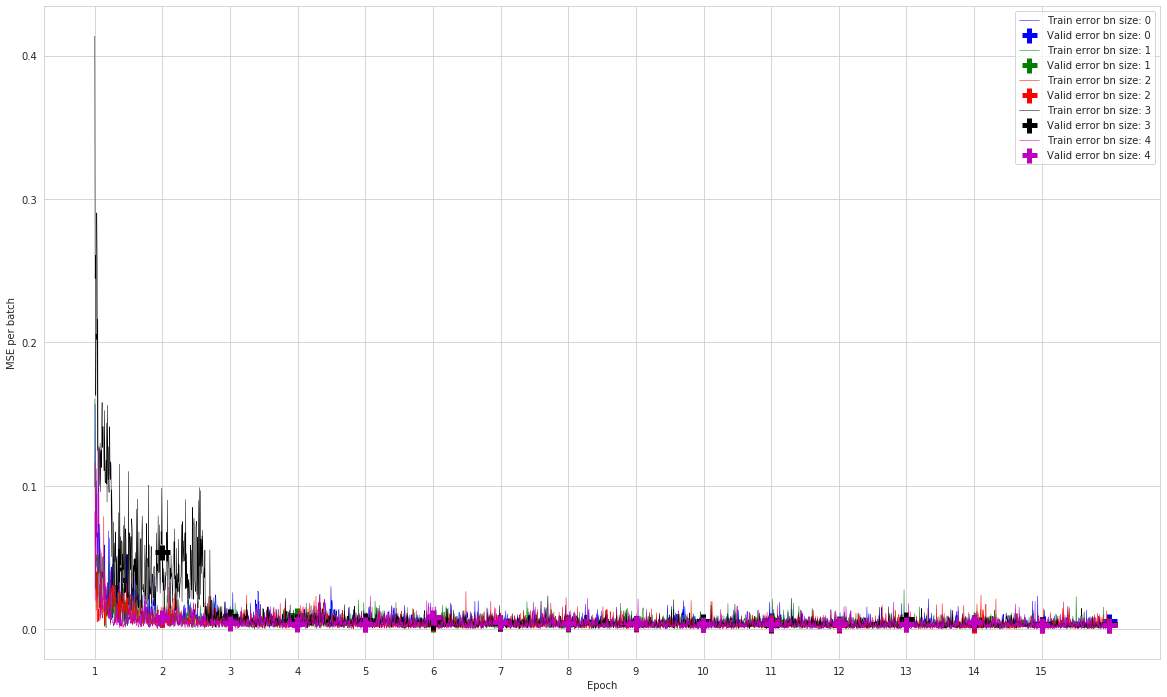

In [29]:
plt.figure(figsize=(20,12))
colors = "bgrkmycw"

for i, bn_size in enumerate(dic_nets.keys()):
    plt.plot(tr_losses[bn_size][0], tr_losses[bn_size][1], '-', color=colors[i],
             lw=0.5, label=f'Train error bn size: {bn_size}')
    plt.plot(val_losses[bn_size][0], val_losses[bn_size][1], '+', color=colors[i],
             ms=15.0, mew=5.0, label=f'Valid error bn size: {bn_size}')

plt.xticks(np.arange(0, max(tr_losses[bn_size][0]),
                     step=max(tr_losses[bn_size][0])/hparams1['num_epochs']), 
                     [i + 1 for i in range(hparams1['num_epochs'])])
plt.xlabel('Epoch')
plt.ylabel('MSE per batch')
plt.grid(True)
plt.legend()
plt.show()

In [30]:
for i in range(len(dic_nets.keys())):
  print(val_losses[i][1][14])

0.0056413302760726465
0.003440217916957206
0.0031022974936705497
0.003489613461068883
0.0030897508113412187


In [0]:
val_iter = iter(valid_loader)

inputs, targets, ftr, date = val_iter.next()
outputs = models[2](inputs.to(device))
outputs = outputs.detach().cpu().numpy()
targets = targets.detach().cpu().numpy()

In [32]:
outputs

array([[0.1460263 , 0.20664994, 0.6366087 ],
       [0.5132317 , 0.2408688 , 0.2200816 ],
       [0.0950296 , 0.15923023, 0.72112125],
       [0.7642229 , 0.14354435, 0.08539139],
       [0.83082134, 0.10838623, 0.05972746]], dtype=float32)

In [0]:
data_res = data.copy()
res = pd.concat([pd.DataFrame(targets,columns=['B365H','B365D','B365A']), pd.DataFrame(outputs,columns=['B365H_Pred','B365D_Pred','B365A_Pred'])],axis=1)
res['FTR'] = ftr
res['Date'] = date
N = 10000
#thank you koalo for comment
res.B365H = np.round(res.B365H*N).astype(int) 
data_res.B365H = np.round(data_res.B365H*N).astype(int) 
res.B365D = np.round(res.B365D*N).astype(int) 
data_res.B365D = np.round(data_res.B365D*N).astype(int) 
res.B365A = np.round(res.B365A*N).astype(int) 
data_res.B365A = np.round(data_res.B365A*N).astype(int) 
res = pd.merge(res,data_res,how='left', on=['B365H','B365D','B365A','FTR', 'Date'],)
res.B365H = res.B365H/N
res.B365D = res.B365D/N
res.B365A = res.B365A/N

In [34]:
res

,B365H,B365D,B365A,B365H_Pred,B365D_Pred,B365A_Pred,FTR,Date,HomeTeamPercPoints,HomeTeamGolsFavorMean,HomeTeamGolsFavorMedian,HomeTeamGolsFavorMax,HomeTeamGolsContraMean,HomeTeamGolsContraMedian,HomeTeamGolsContraMax,HomeTeam_Position,HomeTeam_Home_Wins_season,HomeTeam_Away_Wins_season,HomeTeam_Wins_season,HomeTeam_Home_Lose_season,HomeTeam_Away_Lose_season,HomeTeam_Lose_season,HomeTeam_Home_Draw_season,HomeTeam_Away_Draw_season,HomeTeam_Draw_season,HomeTeam_Points,HomeTeam_Home_goals_avg,HomeTeam_Home_goals_med,HomeTeam_Home_goals_max,HomeTeam_Home_goals_mode,HomeTeam_Away_goals_avg,HomeTeam_Away_goals_med,HomeTeam_Away_goals_max,HomeTeam_Away_goals_mode,HomeTeam_AgeMean,HomeTeam_AgeMedian,HomeTeam_DefensaMax,HomeTeam_DefensaMean,HomeTeam_DefensaMedian,HomeTeam_DelanteroMax,...,AwayTeamGolsContraMax,AwayTeam_Position,AwayTeam_Home_Wins_season,AwayTeam_Away_Wins_season,AwayTeam_Wins_season,AwayTeam_Home_Lose_season,AwayTeam_Away_Lose_season,AwayTeam_Lose_season,AwayTeam_Home_Draw_season,AwayTeam_Away_Draw_season,AwayTeam_Draw_season,AwayTeam_Points,AwayTeam_Home_goals_avg,AwayTeam_Home_goals_med,AwayTeam_Home_goals_max,AwayTeam_Home_goals_mode,AwayTeam_Away_goals_avg,AwayTeam_Away_goals_med,AwayTeam_Away_goals_max,AwayTeam_Away_goals_mode,AwayTeam_AgeMean,AwayTeam_AgeMedian,AwayTeam_DefensaMax,AwayTeam_DefensaMean,AwayTeam_DefensaMedian,AwayTeam_DelanteroMax,AwayTeam_DelanteroMean,AwayTeam_DelanteroMedian,AwayTeam_MedioMax,AwayTeam_MedioMean,AwayTeam_MedioMedian,AwayTeam_OverallMax,AwayTeam_OverallMean,AwayTeam_OverallMedian,AwayTeam_PorteroMax,AwayTeam_PorteroMean,AwayTeam_PorteroMedian,AwayTeam_TopOverallMean,AwayTeam_TopOverallMedian,AwayTeam_TopOverallMin
0,0.1468,0.1908,0.6625,0.146026,0.206650,0.636609,A,14/01/2018,0.425926,1.722222,1.5,4,1.666667,2.0,4,6,10,9,19,4,8,12,5,2,7,64,1.578947,1.0,4,1,1.526316,2.0,3,2,24.625000,23.5,82.0,75.571429,77.0,82.0,...,2,2,15,13,28,1,3,4,3,3,6,90,3.368421,4.0,7,4,2.736842,3.0,6,1,26.520000,27.0,87.0,82.166667,82.0,93.0,84.833333,82.0,87.0,82.600000,82.5,93.0,82.560000,82.0,85.0,78.666667,81.0,86.454545,86.0,70.0
1,0.5627,0.2551,0.1822,0.513232,0.240869,0.220082,H,03/03/2018,0.538462,1.307692,1.0,3,1.538462,1.0,5,4,14,7,21,1,7,8,4,5,9,72,2.052632,2.0,6,2,1.578947,1.0,4,1,26.038462,26.0,81.0,75.857143,79.0,82.0,...,3,7,13,6,19,2,11,13,4,2,6,63,1.894737,2.0,5,2,0.894737,1.0,3,1,25.629630,25.0,84.0,75.333333,76.0,84.0,77.125000,78.0,82.0,75.142857,74.0,84.0,75.703704,76.0,80.0,74.333333,76.0,81.000000,81.0,65.0
2,0.0737,0.1278,0.7985,0.095030,0.159230,0.721121,A,02/04/2017,0.226190,0.892857,1.0,4,2.071429,1.5,7,16,6,4,10,8,11,19,5,4,9,39,1.368421,1.0,5,1,1.052632,1.0,4,0,23.531250,23.0,75.0,70.272727,72.0,78.0,...,4,1,16,13,29,2,3,5,1,3,4,91,3.526316,4.0,6,2,2.368421,2.0,8,2,24.969697,24.0,87.0,76.692308,79.0,93.0,80.833333,85.5,88.0,79.500000,81.5,93.0,78.090909,80.0,83.0,75.000000,75.5,87.454545,87.0,63.0
3,0.7568,0.1802,0.0631,0.764223,0.143544,0.085391,H,28/02/2018,0.773333,1.640000,1.0,5,0.440000,0.0,2,3,14,9,23,3,3,6,2,7,9,78,2.105263,1.0,7,1,1.578947,1.0,5,1,24.781250,23.5,88.0,77.400000,80.5,88.0,...,3,17,5,3,8,8,11,19,6,5,11,35,1.157895,1.0,4,0,0.736842,1.0,2,1,26.600000,27.0,76.0,73.555556,73.0,78.0,72.166667,74.0,79.0,72.333333,74.5,79.0,72.833333,74.0,76.0,74.000000,75.0,76.090909,75.0,60.0
4,0.8491,0.1057,0.0453,0.830821,0.108386,0.059727,H,22/12/2018,0.708333,2.875000,2.5,8,1.187500,1.0,4,1,16,12,28,0,1,1,3,6,9,93,2.789474,2.0,6,2,2.421053,2.0,5,2,23.848485,23.0,87.0,77.181818,81.0,94.0,...,4,13,8,5,13,3,12,15,8,2,10,49,1.789474,2.0,4,2,1.315789,1.0,5,1,23.666667,23.0,80.0,70.916667,72.5,84.0,74.333333,76.0,78.0,72.666667,75.0,84.0,72.454545,75.0,78.0,74.000000,76.0,78.181818,78.0,61.0


In [0]:
def getMin(a):
  aux = min(a)
  for lletra in ['H','D','A']:
    if aux == a[lletra]:
      return lletra

In [0]:
res['H'] = res['B365H'] - res['B365H_Pred']
res['D'] = res['B365D'] - res['B365D_Pred']
res['A'] = res['B365A'] - res['B365A_Pred']
a = res[['H','D','A']].copy()
res['Win'] = a.apply(getMin,axis=1)

In [0]:
comp = res[['Win','FTR','Date','HomeTeam_DelanteroMax','HomeTeam_MedioMax','HomeTeam_PorteroMax','AwayTeam_DelanteroMax','AwayTeam_MedioMax','AwayTeam_PorteroMax']].copy()

In [38]:
comp.head()

,Win,FTR,Date,HomeTeam_DelanteroMax,HomeTeam_MedioMax,HomeTeam_PorteroMax,AwayTeam_DelanteroMax,AwayTeam_MedioMax,AwayTeam_PorteroMax
0,D,A,14/01/2018,82.0,81.0,83.0,93.0,87.0,85.0
1,A,H,03/03/2018,82.0,83.0,82.0,84.0,82.0,80.0
2,D,A,02/04/2017,78.0,78.0,79.0,93.0,88.0,83.0
3,A,H,28/02/2018,88.0,85.0,88.0,78.0,79.0,76.0
4,A,H,22/12/2018,94.0,89.0,89.0,84.0,78.0,78.0


In [0]:
data2 = pd.read_csv(PATH_TO_DATA+'/Generated/DB20200101.csv')

In [40]:
data2.head()

,Unnamed: 0,B365H,B365D,B365A,FTR,Date,HomeTeam,AwayTeam,HomeTeamPercPoints,HomeTeamGolsFavorMean,HomeTeamGolsFavorMedian,HomeTeamGolsFavorMax,HomeTeamGolsContraMean,HomeTeamGolsContraMedian,HomeTeamGolsContraMax,HomeTeam_Position,HomeTeam_Home_Wins_season,HomeTeam_Away_Wins_season,HomeTeam_Wins_season,HomeTeam_Home_Lose_season,HomeTeam_Away_Lose_season,HomeTeam_Lose_season,HomeTeam_Home_Draw_season,HomeTeam_Away_Draw_season,HomeTeam_Draw_season,HomeTeam_Points,HomeTeam_Home_goals_avg,HomeTeam_Home_goals_med,HomeTeam_Home_goals_max,HomeTeam_Home_goals_mode,HomeTeam_Away_goals_avg,HomeTeam_Away_goals_med,HomeTeam_Away_goals_max,HomeTeam_Away_goals_mode,HomeTeam_AgeMean,HomeTeam_AgeMedian,HomeTeam_DefensaMax,HomeTeam_DefensaMean,HomeTeam_DefensaMedian,HomeTeam_DelanteroMax,...,AwayTeamGolsContraMax,AwayTeam_Position,AwayTeam_Home_Wins_season,AwayTeam_Away_Wins_season,AwayTeam_Wins_season,AwayTeam_Home_Lose_season,AwayTeam_Away_Lose_season,AwayTeam_Lose_season,AwayTeam_Home_Draw_season,AwayTeam_Away_Draw_season,AwayTeam_Draw_season,AwayTeam_Points,AwayTeam_Home_goals_avg,AwayTeam_Home_goals_med,AwayTeam_Home_goals_max,AwayTeam_Home_goals_mode,AwayTeam_Away_goals_avg,AwayTeam_Away_goals_med,AwayTeam_Away_goals_max,AwayTeam_Away_goals_mode,AwayTeam_AgeMean,AwayTeam_AgeMedian,AwayTeam_DefensaMax,AwayTeam_DefensaMean,AwayTeam_DefensaMedian,AwayTeam_DelanteroMax,AwayTeam_DelanteroMean,AwayTeam_DelanteroMedian,AwayTeam_MedioMax,AwayTeam_MedioMean,AwayTeam_MedioMedian,AwayTeam_OverallMax,AwayTeam_OverallMean,AwayTeam_OverallMedian,AwayTeam_PorteroMax,AwayTeam_PorteroMean,AwayTeam_PorteroMedian,AwayTeam_TopOverallMean,AwayTeam_TopOverallMedian,AwayTeam_TopOverallMin
0,0,2.2,3.2,3.50,D,26/08/2016,Betis,La Coruna,0.000000,2.0,2.0,2,6.0,6.0,6,10,6,5,11,7,8,15,6,6,12,45,0.894737,1.0,2,1,0.894737,1.0,3,1,26.142857,25.0,78.0,73.555556,73.0,81.0,...,1,15,4,4,8,7,5,12,8,10,18,42,1.315789,1.0,3,2,1.052632,1.0,3,1,25.666667,25.0,79.0,74.625000,75.0,79.0,68.500000,67.0,79.0,72.062500,74.0,79.0,72.151515,75.0,75.0,73.333333,75.0,77.272727,77.0,61.0
1,1,2.3,3.1,3.40,D,26/08/2016,Espanol,Malaga,0.000000,4.0,4.0,4,6.0,6.0,6,14,9,3,12,5,14,19,5,2,7,43,1.157895,1.0,4,1,0.947368,1.0,4,0,26.142857,26.0,77.0,73.666667,76.0,80.0,...,1,9,8,4,12,5,9,14,6,6,12,48,1.368421,1.0,4,1,0.631579,0.0,3,0,25.000000,24.0,78.0,73.181818,75.0,77.0,68.875000,71.0,81.0,75.909091,76.0,81.0,73.090909,75.0,81.0,73.666667,78.0,78.272727,78.0,58.0
2,2,2.7,3.2,2.75,H,27/08/2016,Eibar,Valencia,0.000000,1.0,1.0,1,2.0,2.0,2,13,8,3,11,6,11,17,5,5,10,43,1.368421,1.0,5,1,1.210526,1.0,4,0,25.096774,25.0,79.0,72.000000,75.0,78.0,...,4,12,6,5,11,6,10,16,7,4,11,44,1.315789,1.0,4,0,1.105263,1.0,5,0,24.333333,24.0,83.0,74.166667,76.5,83.0,76.375000,76.5,81.0,71.400000,72.5,83.0,73.878788,76.0,82.0,74.333333,75.0,80.181818,79.0,61.0
3,3,8.5,3.6,1.53,D,27/08/2016,Leganes,Ath Madrid,1.000000,1.0,1.0,1,0.0,0.0,0,19,6,3,9,6,14,20,7,2,9,36,1.210526,1.0,4,1,0.736842,0.0,2,0,25.454545,25.0,76.0,70.909091,74.0,73.0,...,1,3,15,13,28,1,5,6,3,1,4,88,1.736842,1.0,5,1,1.578947,1.0,3,1,25.419355,24.0,88.0,77.666667,82.0,88.0,75.666667,80.0,84.0,76.416667,80.5,88.0,76.548387,81.0,87.0,75.750000,75.5,84.636364,84.0,61.0
4,4,3.1,3.1,2.50,A,27/08/2016,Osasuna,Sociedad,0.333333,1.0,1.0,1,1.0,1.0,1,20,7,1,8,7,15,22,5,3,8,32,1.210526,1.0,3,1,0.736842,1.0,3,0,26.030303,27.0,75.0,71.727273,72.0,76.0,...,3,8,7,6,13,7,9,16,5,4,9,48,1.157895,1.0,3,2,1.210526,1.0,5,0,24.939394,24.0,81.0,72.700000,75.5,82.0,74.666667,77.5,79.0,72.230769,73.0,83.0,72.636364,75.0,83.0,70.750000,67.0,79.272727,79.0,60.0


In [0]:
aux = pd.merge(comp,data2,how='left', on=['FTR','Date','HomeTeam_DelanteroMax','HomeTeam_MedioMax','HomeTeam_PorteroMax','AwayTeam_DelanteroMax','AwayTeam_MedioMax','AwayTeam_PorteroMax'],)

In [42]:
aux

,Win,FTR,Date,HomeTeam_DelanteroMax,HomeTeam_MedioMax,HomeTeam_PorteroMax,AwayTeam_DelanteroMax,AwayTeam_MedioMax,AwayTeam_PorteroMax,Unnamed: 0,B365H,B365D,B365A,HomeTeam,AwayTeam,HomeTeamPercPoints,HomeTeamGolsFavorMean,HomeTeamGolsFavorMedian,HomeTeamGolsFavorMax,HomeTeamGolsContraMean,HomeTeamGolsContraMedian,HomeTeamGolsContraMax,HomeTeam_Position,HomeTeam_Home_Wins_season,HomeTeam_Away_Wins_season,HomeTeam_Wins_season,HomeTeam_Home_Lose_season,HomeTeam_Away_Lose_season,HomeTeam_Lose_season,HomeTeam_Home_Draw_season,HomeTeam_Away_Draw_season,HomeTeam_Draw_season,HomeTeam_Points,HomeTeam_Home_goals_avg,HomeTeam_Home_goals_med,HomeTeam_Home_goals_max,HomeTeam_Home_goals_mode,HomeTeam_Away_goals_avg,HomeTeam_Away_goals_med,HomeTeam_Away_goals_max,...,AwayTeamGolsFavorMax,AwayTeamGolsContraMean,AwayTeamGolsContraMedian,AwayTeamGolsContraMax,AwayTeam_Position,AwayTeam_Home_Wins_season,AwayTeam_Away_Wins_season,AwayTeam_Wins_season,AwayTeam_Home_Lose_season,AwayTeam_Away_Lose_season,AwayTeam_Lose_season,AwayTeam_Home_Draw_season,AwayTeam_Away_Draw_season,AwayTeam_Draw_season,AwayTeam_Points,AwayTeam_Home_goals_avg,AwayTeam_Home_goals_med,AwayTeam_Home_goals_max,AwayTeam_Home_goals_mode,AwayTeam_Away_goals_avg,AwayTeam_Away_goals_med,AwayTeam_Away_goals_max,AwayTeam_Away_goals_mode,AwayTeam_AgeMean,AwayTeam_AgeMedian,AwayTeam_DefensaMax,AwayTeam_DefensaMean,AwayTeam_DefensaMedian,AwayTeam_DelanteroMean,AwayTeam_DelanteroMedian,AwayTeam_MedioMean,AwayTeam_MedioMedian,AwayTeam_OverallMax,AwayTeam_OverallMean,AwayTeam_OverallMedian,AwayTeam_PorteroMean,AwayTeam_PorteroMedian,AwayTeam_TopOverallMean,AwayTeam_TopOverallMedian,AwayTeam_TopOverallMin
0,D,A,14/01/2018,82.0,81.0,83.0,93.0,87.0,85.0,547,6.50,5.00,1.44,Sociedad,Barcelona,0.425926,1.722222,1.5,4,1.666667,2.0,4,6,10,9,19,4,8,12,5,2,7,64,1.578947,1.0,4,1,1.526316,2.0,3,...,6,0.388889,0.0,2,2,15,13,28,1,3,4,3,3,6,90,3.368421,4.0,7,4,2.736842,3.0,6,1,26.520000,27.0,87.0,82.166667,82.0,84.833333,82.0,82.600000,82.5,93.0,82.560000,82.0,78.666667,81.0,86.454545,86.0,70.0
1,A,H,03/03/2018,82.0,83.0,82.0,84.0,82.0,80.0,623,1.70,3.75,5.25,Sevilla,Ath Bilbao,0.538462,1.307692,1.0,3,1.538462,1.0,5,4,14,7,21,1,7,8,4,5,9,72,2.052632,2.0,6,2,1.578947,1.0,4,...,3,1.115385,1.0,3,7,13,6,19,2,11,13,4,2,6,63,1.894737,2.0,5,2,0.894737,1.0,3,1,25.629630,25.0,84.0,75.333333,76.0,77.125000,78.0,75.142857,74.0,84.0,75.703704,76.0,74.333333,76.0,81.000000,81.0,65.0
2,D,A,02/04/2017,78.0,78.0,79.0,93.0,88.0,83.0,274,13.00,7.50,1.20,Granada,Barcelona,0.226190,0.892857,1.0,4,2.071429,1.5,7,16,6,4,10,8,11,19,5,4,9,39,1.368421,1.0,5,1,1.052632,1.0,4,...,6,0.892857,1.0,4,1,16,13,29,2,3,5,1,3,4,91,3.526316,4.0,6,2,2.368421,2.0,8,2,24.969697,24.0,87.0,76.692308,79.0,80.833333,85.5,79.500000,81.5,93.0,78.090909,80.0,75.000000,75.5,87.454545,87.0,63.0
3,A,H,28/02/2018,88.0,85.0,88.0,78.0,79.0,76.0,613,1.25,5.25,15.00,Ath Madrid,Leganes,0.773333,1.640000,1.0,5,0.440000,0.0,2,3,14,9,23,3,3,6,2,7,9,78,2.105263,1.0,7,1,1.578947,1.0,5,...,3,1.120000,1.0,3,17,5,3,8,8,11,19,6,5,11,35,1.157895,1.0,4,0,0.736842,1.0,2,1,26.600000,27.0,76.0,73.555556,73.0,72.166667,74.0,72.333333,74.5,79.0,72.833333,74.0,74.000000,75.0,76.090909,75.0,60.0
4,A,H,22/12/2018,94.0,89.0,89.0,84.0,78.0,78.0,894,1.12,9.00,21.00,Barcelona,Celta,0.708333,2.875000,2.5,8,1.187500,1.0,4,1,16,12,28,0,1,1,3,6,9,93,2.789474,2.0,6,2,2.421053,2.0,5,...,4,1.500000,1.0,4,13,8,5,13,3,12,15,8,2,10,49,1.789474,2.0,4,2,1.315789,1.0,5,1,23.666667,23.0,80.0,70.916667,72.5,74.333333,76.0,72.666667,75.0,84.0,72.454545,75.0,74.000000,76.0,78.181818,78.0,61.0


In [0]:
def getWinning(d):
  if d['Win'] == d['FTR']:
    return d['B365'+d['Win']]
  else:
    #return d['B365'+d['Win']]
    return 0

In [0]:
def getWinnerDif(d):
  aux = min(d)
  for lletra in ['H','D','A']:
    if aux == a[lletra]:
      return lletra

In [86]:
print(results)

0    0
1    1
2    0
3    1
dtype: int64


In [87]:
print(results.sum())

2


In [95]:
data2 = pd.read_csv(PATH_TO_DATA+'/Generated/DB20200101.csv')
val_iter = iter(valid_loader)
tot = 0
for inputs, targets, ftr, date in val_iter:
  inputs, targets, ftr, date = val_iter.next()
  outputs = models[2](inputs.to(device))
  outputs = outputs.detach().cpu().numpy()
  targets = targets.detach().cpu().numpy()

  data_res = data.copy()
  res = pd.concat([pd.DataFrame(targets,columns=['B365H','B365D','B365A']), pd.DataFrame(outputs,columns=['B365H_Pred','B365D_Pred','B365A_Pred'])],axis=1)
  res['FTR'] = ftr
  res['Date'] = date
  N = 10000
  #thank you koalo for comment
  res.B365H = np.round(res.B365H*N).astype(int) 
  data_res.B365H = np.round(data_res.B365H*N).astype(int) 
  res.B365D = np.round(res.B365D*N).astype(int) 
  data_res.B365D = np.round(data_res.B365D*N).astype(int) 
  res.B365A = np.round(res.B365A*N).astype(int) 
  data_res.B365A = np.round(data_res.B365A*N).astype(int) 
  res = pd.merge(res,data_res,how='left', on=['B365H','B365D','B365A','FTR', 'Date'],)
  res.B365H = res.B365H/N
  res.B365D = res.B365D/N
  res.B365A = res.B365A/N

  res['H'] = res['B365H'] - res['B365H_Pred']
  res['D'] = res['B365D'] - res['B365D_Pred']
  res['A'] = res['B365A'] - res['B365A_Pred']
  a = res[['H','D','A']].copy()
  res['Win'] = a.apply(getMin,axis=1)

  comp = res[['Win','FTR','Date','HomeTeam_DelanteroMax','HomeTeam_MedioMax','HomeTeam_PorteroMax','AwayTeam_DelanteroMax','AwayTeam_MedioMax','AwayTeam_PorteroMax']].copy()
  aux = pd.merge(comp,data2,how='left', on=['FTR','Date','HomeTeam_DelanteroMax','HomeTeam_MedioMax','HomeTeam_PorteroMax','AwayTeam_DelanteroMax','AwayTeam_MedioMax','AwayTeam_PorteroMax'])
  aux[''].apply(min,axis=1)
  results = aux.apply(getWinning,axis=1)
  #print(results)
  print(res[['B365H','B365H_Pred','B365D','B365D_Pred','B365A','B365A_Pred','H','D','A','Win','FTR']])
  print(results.sum())
  tot += results.sum() - 5


    B365H  B365H_Pred   B365D  B365D_Pred   B365A  B365A_Pred         H  \
0  0.5152    0.554971  0.2647    0.240251  0.2201    0.189710 -0.039771   
1  0.4458    0.454048  0.2891    0.263519  0.2650    0.262900 -0.008248   
2  0.6776    0.690431  0.2108    0.182547  0.1116    0.116153 -0.012831   
3  0.5485    0.639180  0.2550    0.211949  0.1965    0.140108 -0.090680   
4  0.4543    0.462503  0.2806    0.274074  0.2650    0.254263 -0.008203   

          D         A Win FTR  
0  0.024449  0.030390   H   H  
1  0.025581  0.002100   H   H  
2  0.028253 -0.004553   H   H  
3  0.043051  0.056392   H   D  
4  0.006526  0.010737   H   A  
5.390000000000001
    B365H  B365H_Pred   B365D  B365D_Pred   B365A  B365A_Pred         H  \
0  0.6349    0.679083  0.2381    0.187289  0.1270    0.121329 -0.044183   
1  0.4481    0.518428  0.2483    0.237928  0.3036    0.214221 -0.070328   
2  0.7440    0.821456  0.1920    0.112384  0.0640    0.062513 -0.077456   
3  0.5157    0.668449  0.2935    0.1956

In [90]:
tot

-9.719999999999999